# **Case Study: Yelp Restaurant Recommendation System**

---------------
## **Context**
---------------

**Yelp** was founded in **2004** to help people find **great local businesses**. Today, the website and their mobile application publish crowd-sourced reviews about local businesses as well as certain metadata about them that can help in customer's **decision-making process**. Yelp uses automated software to recommend the **most helpful** and **reliable reviews** for the Yelp community from such a large and diverse dataset.

The Yelp dataset is a large collection of user reviews, business metadata, business check-ins, users' social network data, user tips for businesses across 10 cities spread across **4 countries**. The original dataset is very huge with ~ 11GB of data. In this case study, we will only use a subset of data due to the hardware limitations.

-----------------
## **Objective**
-----------------

In this case study, we will build four types of recommendation systems: 
- **Knowledge/Rank Based recommendation system**
- **Similarity-Based Collaborative filtering**
- **Matrix Factorization Based Collaborative Filtering**
- **Clustering based recommendation system**


-----------------
## **Dataset**
-----------------

Out of many attributes available in the yelp_reviews data, we will only use the following four attributes:
- business_id
- business_name
- stars
- user_id

## **Import Libraries**

In [2]:
# from google.colab import drive 
# dirve.mount('/content/drive/Mydrive')

In [3]:
import pandas as pd 
import numpy as np 

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
import seaborn as sns 

from collections import defaultdict

from surprise import accuracy, CoClustering
from surprise.reader import Reader 
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV, train_test_split, KFold
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD

from sklearn.metrics import mean_squared_error

## **Import Data**

- based on the problem estatement we only should use these column info (business_id, business_name, stars, and user_id)

In [4]:
yelp_review = pd.read_csv('yelp_reviews.csv', usecols=['business_id', 'business_name', 'stars',  'user_id'])
yelp_review.head()

,business_id,business_name,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,Morning Glory Cafe,5,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,Spinato's Pizzeria,5,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,Haji-Baba,4,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,Chaparral Dog Park,5,uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,Discount Tire,5,vYmM4KTsC8ZfQBg-j5MWkw


In [5]:
yelp_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   business_id    229907 non-null  object
 1   business_name  229907 non-null  object
 2   stars          229907 non-null  int64 
 3   user_id        229907 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.0+ MB


- The dataset includes 229,907 resturant info. It has 4 columns which 3 are onjects and 1 intiger.
- we don't need both bussiness name and id we can drop the bussiness name and just keep the bussiness id. 

In [6]:
yelp_review.drop('business_name', axis=1, inplace=True)

In [7]:
yelp_review.duplicated().sum()

1

In [8]:
yelp_review.isnull().sum()

business_id    0
stars          0
user_id        0
dtype: int64

- We have zero missing data but one duplicate datapoint. 

## **Explotary Data Analysis**

In [9]:
yelp_review['business_id'].nunique()

11537

In [10]:
yelp_review['user_id'].nunique()

45981

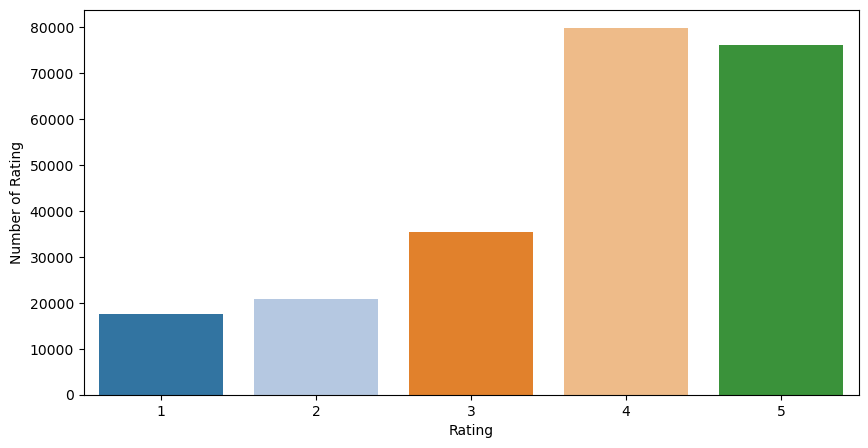

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(data=yelp_review, x='stars', palette='tab20')
plt.xlabel('Rating')
plt.ylabel('Number of Rating')
plt.show()

- The dataset includes 11,537 unique bussinesses. 
- The dataset has rating from 45,981 unique users.
- The user item interaction matrix is 45981 X 11537. This matrix has ~53e7 elements. we onlt have ~2.3e5 rating so lot's of data points are missing. 
- The rating is skewed toward 4 and 5 ratings. with 4 having the highest number of occurance. This might already indicates that people that doesn't like the resturant usually don't tend to rate the place. 


In [12]:
yelp_review['business_id'].value_counts()

business_id
hW0Ne_HTHEAgGF1rAdmR-g    844
VVeogjZya58oiTxK7qUjAQ    794
JokKtdXU7zXHcr20Lrk29A    731
ntN85eu27C04nwyPa8IHtw    679
EWMwV5V9BxNs_U6nNVMeqw    645
                         ... 
-NbEHP2GHFNb5PnmJnd4qQ      3
QICgwHWhXIbihfcMKtws8g      3
sAwxt4I4gTiL-08nyarJbg      3
huzUWI5YqkJEEIudo0YiDg      3
SeCVec3f91bEdosAILE4JA      3
Name: count, Length: 11537, dtype: int64

- The highest number of rating for one bussiness is 844. 

In [13]:
yelp_review['user_id'].value_counts()

user_id
fczQCSmaWF78toLEmb0Zsw    588
90a6z--_CUrl84aCzZyPsg    506
0CMz8YaO3f8xu4KqQgKb9Q    473
4ozupHULqGyO42s3zNUzOQ    442
joIzw_aUiNvBTuGoytrH7g    392
                         ... 
Oh9OOyDSGf4eNWGiNazh8g      1
Np9IEqnLmhRB2T5jumPTGw      1
g0-ejhzvo0ELNp04cUKWDg      1
M0lyA1jF0zrXZr5TXlioTQ      1
dDNfSFT0VApxPmURclX6_g      1
Name: count, Length: 45981, dtype: int64

- The most active user left 588 reviewes in the system. 

In [14]:
yelp_review.groupby(['user_id', 'business_id']).count()['stars'].sum()

229907

- The sum is equal to the number of data points meaning that we don't have rating for the same user and same resutrnat more than once. 

In [15]:
yelp_review[yelp_review['business_id'] == 'hW0Ne_HTHEAgGF1rAdmR-g']['stars'].value_counts()

stars
4    292
3    280
2    140
5     78
1     54
Name: count, dtype: int64

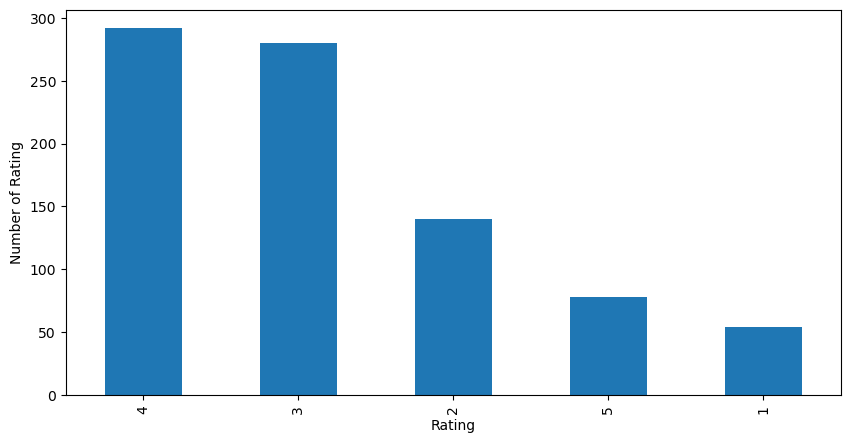

In [16]:
plt.figure(figsize=(10, 5))
yelp_review[yelp_review['business_id'] == 'hW0Ne_HTHEAgGF1rAdmR-g']['stars'].value_counts().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of Rating')
plt.show()

- This is information for the resturant with highest number of rating. Most of the rating are 4 and 3 starts. 
This resturant overall liked by majority of the users. 

## **Data Preprose**

Due to hardware limitation I need to reduce size of. To do that we only consider users that have more than 100 rating in their profile.

In [17]:
df = yelp_review[yelp_review['user_id'].map(yelp_review['user_id'].value_counts()) >= 100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35769 entries, 0 to 229905
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  35769 non-null  object
 1   stars        35769 non-null  int64 
 2   user_id      35769 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Through this process we decrease the size of dataset to 35,769 data points. 

## **Building Models**

### **Model 1: Ranked-Based Recom. Sys.**

In [18]:
avg_rating = yelp_review.groupby('business_id')['stars'].mean()
count_rating = yelp_review.groupby('business_id')['stars'].count()

rating = pd.DataFrame({'avg_rating': avg_rating, 'rating_freq': count_rating})
rating.head()

,avg_rating,rating_freq
business_id,,
--5jkZ3-nUPZxUvtcbr8Uw,4.545455,11
--BlvDO_RG2yElKu9XA1_g,4.162162,37
-0D_CYhlD2ILkmLR0pBmnA,4.000000,5
-0QBrNvhrPQCaeo7mTo0zQ,4.333333,3
-0bUDim5OGuv8R0Qqq6J4A,2.333333,6


In [19]:
def recom_model(data, n, min_freq):
    recommend = data[data['rating_freq'] > min_freq].sort_values(by='avg_rating', ascending = False)
    return recommend.index[:n]

In [20]:
recom_model(rating, 5, 50 )

Index(['8HQ8clouLGgee99KkR4vXA', 'CKjcewWeWvdJ7TzOQbZOIw',
       '97Z7j4vH0kfzL10AONi4uA', '_TekkyyFeX_8MBepPIxuTg',
       'L-uPZxooP_ziXCtRrWi8Pw'],
      dtype='object', name='business_id')

- These are the songs that are popular. 

### **Similarity Based Collaborative Filtering Recom. Sys.**

`Relevant Business`: Businesses that rated higher than the threshold is relevant. If the actual rating of business is below threshold then it is non-relevant. 
<br>
<br>
`Recommended Business`: Businesses that predicted rating higher than the threshold is recommended business. If the predicated rating is below threshold then the business will not be recommended to the user.
<br>
<br>
`False Negative`: It is the frequency relevent businesses that are not recommended to the users. This is **opportunity loss** for the service provider. 
<br>
<br>
`False Positive`: It is the frequency of recommended businesses that are actually not relevent. This is **recouce loss** for the service provider. 
<br>
<br>
`Recall`: It is the fraction of actually relevant businesses that recommended to the user.
<br>
<br>
`Precision`: It is the fraction of recommended businesses that are relevent actually. 
<br>
<br>
`Recall@k`: It is the fraction of relevant businesses that are recommended to the user in **top k** predications.
<br>
<br>
`Precision@k`: It is the fraction of recommended businesses that are relevent in **top k** predications.
<br>
<br>
`F1-socre@k`: It is the harmonic mean of precision@k and recall@k.


In [21]:
def performance_at_k(model, data,  k, threshold): 
    user_predict_true = defaultdict(list)
    predictions = model.test(data)
    #Prediction format: Prediction(uid=26071, iid=7103, r_ui=1.0, est=1.625, details={'actual_k': 40, 'was_impossible': False})

    for uid, _,true_r, pred, _ in predictions: 
        user_predict_true[uid].append((pred,true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_predict_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        num_relevent = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        num_recom_k = sum((pred >= threshold) for (pred, _) in user_ratings[:k])

        num_relevent_recom_k = sum(((true_r >= threshold) and (pred >= threshold))
                              for (pred, true_r) in user_ratings[:k])

        precisions[uid] = num_relevent_recom_k / num_recom_k if num_recom_k != 0 else 0
        recalls[uid] = num_relevent_recom_k / num_relevent if num_relevent != 0 else 0
    
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) 
    print('Recall: ', recall) 
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) 

In [22]:
reader = Reader(rating_scale=(0,5))
user_buss_matrix = Dataset.load_from_df(df[['user_id', 'business_id', 'stars']], reader)

In [23]:
train_set, test_set = train_test_split(user_buss_matrix, test_size=0.2, random_state=42)

#### **Model 2: User-User Similarity Based Recom. Sys.**

In [24]:
sim_options = {'name': 'cosine',
                'user_based': True}

user_user_sim = KNNBasic(sim_options = sim_options, verbose= False,
                        random_state = 1)

user_user_sim.fit(train_set)
        

In [25]:
performance_at_k(user_user_sim, test_set, 10, 3.5)

RMSE: 1.0409
Precision:  0.773
Recall:  0.417
F_1 score:  0.542


- In the yelp profile the first page of recommendation is very important and should be relevent. So we are going to look at the first 10 items and try to get recall and precision for those. 
- The precision is 77.3% which means out of the 10 recommended resturants 77.3% of them are relevent. 
- The recall is ~42% which indicates that out of all relevant resturants only 42% were recommended. 
- Let's do hyperparameter tuning to improve these values. 

In [26]:
yelp_review[(yelp_review['user_id'] == 'rLtl8ZkDX5vH5nAx9C3q5Q') & (yelp_review['business_id']=='9yKzy9PApeiPPOUJEtnvkg')]

,business_id,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,5,rLtl8ZkDX5vH5nAx9C3q5Q


In [27]:
# let's predict value for specific user and it. 
user_user_sim.predict('rLtl8ZkDX5vH5nAx9C3q5Q', '9yKzy9PApeiPPOUJEtnvkg', r_ui=5)

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.7675091038953616, details={'actual_k': 16, 'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: '9yKzy9PApeiPPOUJEtnvkg' the actual rating is 5 and this model predict 3.76. 

In [28]:
yelp_review[(yelp_review['user_id'] == 'rLtl8ZkDX5vH5nAx9C3q5Q') & (yelp_review['business_id']=='zp713qNhx8d9KCJJnrw1xA')]

,business_id,stars,user_id


In [29]:
# let's predict value for specific user and it. 
user_user_sim.predict('rLtl8ZkDX5vH5nAx9C3q5Q', 'zp713qNhx8d9KCJJnrw1xA')

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.873369257511826, details={'actual_k': 28, 'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: 'zp713qNhx8d9KCJJnrw1xA' which no rating is available the model predict 3.87. 

#### **Model 3: User-User Similarity Based Recom. Sys. - Hyperparameter Tuning**

Hyperparameters for KNNBasic algorithm are: 
- k --> Maximum number of neighbors to take into account for aggregation. Default k = 40
- min_k --> Minimum number of neighbors to take into account for aggregation. Default min_k = 1
- sim_options: 
    - Similarity measures: 
        `cosine` - Compute the cosine similarity between all pairs of users.

        `msd` - Compute the Mean Squared Difference similarity between all pairs of users.

        `pearson` - Compute the Pearson correlation coefficient between all pairs of users.

        `pearson_baseline` - Compute the (shrunk) Pearson correlation coefficient between all pairs of users using baselines for centering instead of means.

In [30]:
param_grid_uu = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
                }

user_user_sim_tune = GridSearchCV(KNNBasic, param_grid_uu,
                        measures=['rmse'],
                        cv = 3, n_jobs=-1)

user_user_sim_tune.fit(user_buss_matrix)

print(user_user_sim_tune.best_score['rmse'])
print(user_user_sim_tune.best_params['rmse'])

1.0146932135173186
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': True}}


In [31]:
sim_para = {'name':'msd', 'user_based':True}

user_user_sim_optimized = KNNBasic(sim_options =sim_para , k= 40, min_k= 6, random_state=1, verbose=False)
user_user_sim_optimized.fit(train_set)

In [32]:
performance_at_k(user_user_sim_optimized, test_set, 10, 3.5)

RMSE: 1.0043
Precision:  0.758
Recall:  0.411
F_1 score:  0.533


- The tune model perofrmance is worst than the baseline! 

In [33]:
user_user_sim_optimized.predict('rLtl8ZkDX5vH5nAx9C3q5Q', '9yKzy9PApeiPPOUJEtnvkg', r_ui=5)

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.9046318384360976, details={'actual_k': 16, 'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: '9yKzy9PApeiPPOUJEtnvkg' the actual rating is 5 and this model predict 3.90. 

In [34]:
# let's predict value for specific user and it. 
user_user_sim_optimized.predict('rLtl8ZkDX5vH5nAx9C3q5Q', 'zp713qNhx8d9KCJJnrw1xA')

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.9506906733620437, details={'actual_k': 28, 'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: 'zp713qNhx8d9KCJJnrw1xA' which no rating is available the model predict 3.95. 

#### **Implement the Recom. Sys.**

In [35]:
def recom_model2(model, data, user_id, top_n_buss):
    recom = []
    user_item_inter_matrix = data.pivot_table(index='user_id', columns='business_id', values='stars')
    non_inter_bussiness= user_item_inter_matrix.loc[user_id][user_item_inter_matrix.loc[user_id].isnull()].index.tolist()
    for item_id in non_inter_bussiness:
        est_buss_score = model.predict(user_id, item_id).est
        recom.append((item_id, est_buss_score))
    recom.sort(key=lambda x:x[1], reverse=True)

    return recom[:top_n_buss]

In [36]:
proposed_buss = recom_model2(user_user_sim, df, 'rLtl8ZkDX5vH5nAx9C3q5Q', 5)
pd.DataFrame(proposed_buss, columns=['business_id', 'predicated_rating'])

,business_id,predicated_rating
0,--5jkZ3-nUPZxUvtcbr8Uw,5
1,-7XuLxfYwZ9x72mEKXdv0A,5
2,-A82xEVAjOYZtDdRQw1FQw,5
3,-CZ78c-H3tTxpP-uQ09CWw,5
4,-J0jhpG0rv4saq9OMh8gXw,5


**Correcting the recommendation based on ranking**

Let's combine the user user collberative filtering with popular resutants ranking system in the model. 

In [37]:
def ranking_user_buss(proposed_buss, ranking_buss):
    buss_rank = ranking_buss.loc[[items[0] for items in proposed_buss]].sort_values('rating_freq', ascending=False)[['rating_freq']].reset_index()
    buss_rank = buss_rank.merge(pd.DataFrame(proposed_buss, columns=['business_id', 'predicated_rating']), on='business_id', how='inner')
    buss_rank['corrected_ranting'] = buss_rank['predicated_rating'] - 1 / np.sqrt(buss_rank['rating_freq'])
    return buss_rank.sort_values('corrected_ranting', ascending=False)

In [38]:
ranking_user_buss(proposed_buss, rating)

,business_id,rating_freq,predicated_rating,corrected_ranting
0,--5jkZ3-nUPZxUvtcbr8Uw,11,5,4.698489
1,-J0jhpG0rv4saq9OMh8gXw,6,5,4.591752
2,-7XuLxfYwZ9x72mEKXdv0A,5,5,4.552786
3,-A82xEVAjOYZtDdRQw1FQw,5,5,4.552786
4,-CZ78c-H3tTxpP-uQ09CWw,3,5,4.422650


#### **Model 4: Item-Item Similarity Based Recom. Sys.**

In [39]:
sim_options = {'name': 'cosine',
                'user_based': False}

item_item_sim = KNNBasic(sim_options = sim_options, verbose= False,
                        random_state = 1)

item_item_sim.fit(train_set)

In [40]:
performance_at_k(item_item_sim, test_set, 10, 3.5)

RMSE: 1.0218
Precision:  0.663
Recall:  0.344
F_1 score:  0.453


- This is performing worst than the user user similarity based system. 
- The precision is 66.3% which means out of the 10 recommended resturants 66.3% of them are relevent. 
- The recall is ~34.4% which indicates that out of all relevant resturants only 34.4% were recommended. 
- Let's do hyperparameter tuning to improve these values. 

In [41]:
# let's predict value for specific user and it. 
item_item_sim.predict('rLtl8ZkDX5vH5nAx9C3q5Q', '9yKzy9PApeiPPOUJEtnvkg', r_ui=5)

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.475, details={'actual_k': 40, 'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: '9yKzy9PApeiPPOUJEtnvkg' the actual rating is 5 and this model predict 3.47. 

In [42]:
# let's predict value for specific user and it. 
item_item_sim.predict('rLtl8ZkDX5vH5nAx9C3q5Q', 'zp713qNhx8d9KCJJnrw1xA')

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.775, details={'actual_k': 40, 'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: 'zp713qNhx8d9KCJJnrw1xA' which no rating is available the model predict 3.77. 

#### **Model 5: Item-Item Similarity Based Recom. Sys. - Hyperparameter Tuning**

In [43]:
param_grid_ii = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
                              'user_based': [False]}
                }

item_item_sim_tune = GridSearchCV(KNNBasic, param_grid_ii,
                        measures=['rmse'],
                        cv = 3, n_jobs=-1)

item_item_sim_tune.fit(user_buss_matrix)

print(item_item_sim_tune.best_score['rmse'])
print(item_item_sim_tune.best_params['rmse'])

1.0085537488128018
{'k': 40, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


In [44]:
sim_para = {'name':'msd', 'user_based':False}

item_item_sim_optimized = KNNBasic(sim_options =sim_para , k= 40, min_k= 9, random_state=1, verbose=False)
item_item_sim_optimized.fit(train_set)

In [45]:
performance_at_k(item_item_sim_optimized, test_set, 10, 3.5)

RMSE: 0.9970
Precision:  0.716
Recall:  0.379
F_1 score:  0.496


- Still the perofrmance is worst than user-user similarity based recommendation system but better than the baseline.

In [48]:
item_item_sim_optimized.predict('rLtl8ZkDX5vH5nAx9C3q5Q', '9yKzy9PApeiPPOUJEtnvkg', r_ui=5)

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.7592137592137576, details={'actual_k': 40, 'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: '9yKzy9PApeiPPOUJEtnvkg' the actual rating is 5 and this model predict 4.75. 

In [49]:
item_item_sim_optimized.predict('rLtl8ZkDX5vH5nAx9C3q5Q', 'zp713qNhx8d9KCJJnrw1xA')

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.7022994305485457, details={'actual_k': 40, 'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: 'zp713qNhx8d9KCJJnrw1xA' which no rating is available the model predict 3.70. 

#### **Implement the Recom. Sys.**

In [50]:
proposed_buss = recom_model2(item_item_sim_optimized, df, 'rLtl8ZkDX5vH5nAx9C3q5Q', 5)
pd.DataFrame(proposed_buss, columns=['business_id', 'predicated_rating'])

,business_id,predicated_rating
0,5Q49MxuWJgXS649i7i2Iow,4.416667
1,SmY_Xw31b2xyzsKbimQiHQ,4.346154
2,N6ff0yyo9Cv_7XPz-YDoow,4.308696
3,UmFnmIoLCRe1ywY0bzpRrQ,4.307692
4,p204PQg45gECcYwxCAK1wA,4.307692


In [51]:
ranking_user_buss(proposed_buss, rating)

,business_id,rating_freq,predicated_rating,corrected_ranting
1,5Q49MxuWJgXS649i7i2Iow,10,4.416667,4.100439
0,SmY_Xw31b2xyzsKbimQiHQ,15,4.346154,4.087955
2,N6ff0yyo9Cv_7XPz-YDoow,7,4.308696,3.930731
3,UmFnmIoLCRe1ywY0bzpRrQ,4,4.307692,3.807692
4,p204PQg45gECcYwxCAK1wA,3,4.307692,3.730342


### **Model Based Collaborative Filtering Recom. Sys.**

#### **Model 6: Matrix Factorization Recom. Sys.**

In [52]:
svd = SVD(random_state=1)
svd.fit(train_set)

In [53]:
performance_at_k(svd, test_set, 10, 3.5)

RMSE: 0.9630
Precision:  0.77
Recall:  0.383
F_1 score:  0.512


- The precision is 77% which means out of the 10 recommended resturants 77% of them are relevent. 
- The recall is ~38.3% which indicates that out of all relevant resturants only 38.3% were recommended. 
- Let's do hyperparameter tuning to improve these values. 

In [54]:
# let's predict value for specific user and it. 
svd.predict('rLtl8ZkDX5vH5nAx9C3q5Q', '9yKzy9PApeiPPOUJEtnvkg', r_ui=5)

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.155179595069889, details={'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: '9yKzy9PApeiPPOUJEtnvkg' the actual rating is 5 and this model predict 4.15. 

In [55]:
# let's predict value for specific user and it. 
svd.predict('rLtl8ZkDX5vH5nAx9C3q5Q', 'zp713qNhx8d9KCJJnrw1xA')

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=4.09204353877637, details={'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: 'zp713qNhx8d9KCJJnrw1xA' which no rating is available the model predict 4.1. 

#### **Model 7: Matrix Factorization Recom. Sys. - Hyperparameter Tuning**

In [56]:
param_grid_svd= {'n_epochs': [10, 20, 30], 
                 'lr_all': [0.001, 0.005, 0.01], 
                 'reg_all': [0.2, 0.4, 0.6]}

svd_tune = GridSearchCV(SVD, param_grid_svd, measures= ['rmse'], n_jobs=-1, cv=3)
svd_tune.fit(user_buss_matrix)
print(svd_tune.best_score['rmse'])
print(svd_tune.best_params['rmse'])

0.9578466550375012
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [57]:
svd_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2, random_state=1)
svd_optimized.fit(train_set)

In [58]:
performance_at_k(svd_optimized, test_set, 10, 3.5)

RMSE: 0.9507
Precision:  0.79
Recall:  0.406
F_1 score:  0.536


- The perofemance of the tuned model is better than the baseline model. 

In [59]:
svd_optimized.predict('rLtl8ZkDX5vH5nAx9C3q5Q', '9yKzy9PApeiPPOUJEtnvkg', r_ui=5)

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.932454657847243, details={'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: '9yKzy9PApeiPPOUJEtnvkg' the actual rating is 5 and this model predict 3.93. 

In [60]:
svd_optimized.predict('rLtl8ZkDX5vH5nAx9C3q5Q', 'zp713qNhx8d9KCJJnrw1xA')

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.971056550203264, details={'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: 'zp713qNhx8d9KCJJnrw1xA' which no rating is available the model predict 3.97. 

#### **Implement the Recom. Sys.**

In [61]:
proposed_buss = recom_model2(svd_optimized, df, 'rLtl8ZkDX5vH5nAx9C3q5Q', 5)
pd.DataFrame(proposed_buss, columns=['business_id', 'predicated_rating'])

,business_id,predicated_rating
0,X3icXUyW9vS4UXY6V_MR4w,4.789969
1,XRBTHOXaJK_AJ2wy5mX_1A,4.754191
2,4SviSw8uRF0ddj_HxUVnuA,4.731789
3,mQde7KRomOQoUyPGTqeXhA,4.730324
4,97Z7j4vH0kfzL10AONi4uA,4.708755


In [62]:
ranking_user_buss(proposed_buss, rating)

,business_id,rating_freq,predicated_rating,corrected_ranting
0,X3icXUyW9vS4UXY6V_MR4w,79,4.789969,4.677460
1,97Z7j4vH0kfzL10AONi4uA,78,4.708755,4.595527
2,mQde7KRomOQoUyPGTqeXhA,34,4.730324,4.558825
3,XRBTHOXaJK_AJ2wy5mX_1A,26,4.754191,4.558075
4,4SviSw8uRF0ddj_HxUVnuA,10,4.731789,4.415561


### **Clustering-Based Recom. Sys.**

#### **Model 8: Coclustering Recom. Sys.**

In [63]:
coclustering_model = CoClustering(random_state=1)
coclustering_model.fit(train_set)

In [64]:
performance_at_k(coclustering_model, test_set, 10, 3.5)

RMSE: 1.0378
Precision:  0.765
Recall:  0.403
F_1 score:  0.528


- The precision is 76.5% which means out of the 10 recommended resturants 76.5% of them are relevent. 
- The recall is ~40.3% which indicates that out of all relevant resturants only 40.3% were recommended. 
- Let's do hyperparameter tuning to improve these values. 

In [65]:
coclustering_model.predict('rLtl8ZkDX5vH5nAx9C3q5Q', '9yKzy9PApeiPPOUJEtnvkg', r_ui=5)

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.966289107885623, details={'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: '9yKzy9PApeiPPOUJEtnvkg' the actual rating is 5 and this model predict 3.96. 

In [66]:
coclustering_model.predict('rLtl8ZkDX5vH5nAx9C3q5Q', 'zp713qNhx8d9KCJJnrw1xA')

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.7039820276856474, details={'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: 'zp713qNhx8d9KCJJnrw1xA' which no rating is available the model predict 3.7.

#### **Model 9: Coclustering Recom. Sys. - Hyperparameter Tuning**

- The parameters that we need to tune are: 

`n_cltr_u` – Number of user clusters. Default is 3.

`n_cltr_i` – Number of item clusters. Default is 3.

`n_epochs` – Number of iteration of the optimization loop. Default is 20.

In [67]:
param_grid_cocluster= {'n_epochs': [10, 20, 30, 40, 50, 60], 
                 'n_cltr_i': [2, 3, 4, 5, 6, 7 ,8], 
                 'n_cltr_u': [2, 3, 4, 5, 6, 7, 8]}

coclustering_tune = GridSearchCV(CoClustering, param_grid_cocluster, measures= ['rmse'], n_jobs=-1, cv=3)
coclustering_tune.fit(user_buss_matrix)
print(coclustering_tune.best_score['rmse'])
print(coclustering_tune.best_params['rmse'])

1.0346206527074424
{'n_epochs': 50, 'n_cltr_i': 2, 'n_cltr_u': 2}


In [68]:
coclustering_optimized = CoClustering(n_epochs=50, n_cltr_i=2, n_cltr_u=2, random_state=1)
coclustering_optimized.fit(train_set)

In [69]:
performance_at_k(coclustering_optimized, test_set, 10, 3.5)

RMSE: 1.0295
Precision:  0.762
Recall:  0.402
F_1 score:  0.526


The performance of the base model is better than the tuned model. 

In [70]:
coclustering_optimized.predict('rLtl8ZkDX5vH5nAx9C3q5Q', '9yKzy9PApeiPPOUJEtnvkg', r_ui=5)

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.933737152286369, details={'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: '9yKzy9PApeiPPOUJEtnvkg' the actual rating is 5 and this model predict 3.93. 

In [71]:
coclustering_optimized.predict('rLtl8ZkDX5vH5nAx9C3q5Q', 'zp713qNhx8d9KCJJnrw1xA')

Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.7454293705545654, details={'was_impossible': False})

- For user: rLtl8ZkDX5vH5nAx9C3q5Q' and bussiness: 'zp713qNhx8d9KCJJnrw1xA' which no rating is available the model predict 3.74. 

#### **Implement the Recom. Sys.**

In [72]:
proposed_buss = recom_model2(coclustering_optimized, df, 'rLtl8ZkDX5vH5nAx9C3q5Q', 5)
pd.DataFrame(proposed_buss, columns=['business_id', 'predicated_rating'])

,business_id,predicated_rating
0,--5jkZ3-nUPZxUvtcbr8Uw,5
1,-7XuLxfYwZ9x72mEKXdv0A,5
2,-A82xEVAjOYZtDdRQw1FQw,5
3,-JYWpdJfMkqCTA_7fyz6Cw,5
4,-JaNk2DOQdpjTl5Bu-iehg,5


In [73]:
ranking_user_buss(proposed_buss, rating)

,business_id,rating_freq,predicated_rating,corrected_ranting
0,--5jkZ3-nUPZxUvtcbr8Uw,11,5,4.698489
1,-7XuLxfYwZ9x72mEKXdv0A,5,5,4.552786
2,-A82xEVAjOYZtDdRQw1FQw,5,5,4.552786
3,-JYWpdJfMkqCTA_7fyz6Cw,4,5,4.500000
4,-JaNk2DOQdpjTl5Bu-iehg,3,5,4.422650


## **Conclusion**